In [ ]:
#9 Từ bộ dữ liệu Income-Classification hãy chuẩn hóa dữ liệu và phân chia tập train/test theo tỷ lệ 80/20.
from google.colab import drive
import os
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
os.chdir("gdrive/MyDrive/Colab Notebooks/DeepLearning2/4.DeepNeuralNetwork")

In [ ]:
import numpy as np
import random
import pandas as pd
import re
import torch.nn as nn
import torch

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
def seed_all(seed):
    np.random.seed(seed)
    random.seed(seed)
seed = 42 
seed_all(seed)

In [ ]:
#metric
def get_metrics(y_test, y_pred):
    print('ACCURACY_SCORE: ', round(accuracy_score(y_test, y_pred), 4))
    print('F1_SCORE: ', round(f1_score(y_test, y_pred, average='macro'), 4))
    print('CONFUSION_MATRIX:\n', confusion_matrix(y_test, y_pred),'\n')
    print(classification_report(y_test, y_pred, digits=4), '\n')

In [ ]:
df_all = pd.read_csv('../data/income_classification/train.csv')

In [ ]:
# normalize string
def str_normalize(s):
    # convert into lowercase and replace multiple spaces into single space
    s = str(s).strip().lower()
    s = re.sub(' +', " ", s)
    return s
# Encode category and object columns 
def process(df):        
  for col in df.columns:
      if df[col].dtype.name == "object" or df[col].dtype.name == "category":
          df[col] = df[col].apply(str_normalize).astype("category")
  return df
df_all = process(df_all.copy())
IDs=df_all.pop('ID')
label = df_all.pop('target_income')
df_all_one_hot = pd.get_dummies(df_all)

In [ ]:
features = df_all_one_hot.columns.tolist()
label = label.values

In [ ]:
features = df_all_one_hot.columns.tolist()

x_train, x_test, y_train, y_test = train_test_split(df_all_one_hot[features].values, # input variable
                                                    label, # output variable
                                                    test_size=0.2, # test dataset proportion
                                                    # stratify=df_all['target_income'], # assign equal proportion of target label in train/test 
                                                    random_state=0) # keep train/test split the same if run again. 
print ('Training Set: %d, Test Set: %d \n' % (len(x_train), len(x_test)))
#normalize
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

Training Set: 20000, Test Set: 5000 



# Optuna Neural Architecture Search

[Auto-Tuning Hyperparameters with Optuna and PyTorch
](https://www.youtube.com/watch?v=P6NwZVl8ttc) is a good tutorial about search architecture.

In the below, we are going to use optuna to search architecture of model that include:

* Number of layers
* Number of hidden units of each layers
* the optimizer that applies to create the architecture.
* learning rate

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 8.5 MB/s 
     |████████████████████████████████| 210 kB 55.7 MB/s 
     |████████████████████████████████| 80 kB 11.4 MB/s 
     |████████████████████████████████| 75 kB 6.2 MB/s 
     |████████████████████████████████| 113 kB 58.4 MB/s 
     |████████████████████████████████| 149 kB 73.3 MB/s 
     |████████████████████████████████| 49 kB 8.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=ccd1614948dce1038e6efad8f3c02ffe31a91cc997b9db18fa3511e63ef2c144
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna
from optuna.trial import TrialState
import torch.optim as optim
import torch.nn.functional as F

Create the dataset and dataloader for train and test dataset

In [ ]:
import torch
import torch.nn as nn
import torch.utils.data as td

# Set random seed for reproducability
torch.manual_seed(0)

In [ ]:
# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(x_train).float()
# Reshape y target into [-1, 1] to fit with Binary Cross Entropy
train_y = torch.Tensor(y_train).view(-1, 1).float()
train_ds = td.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size=16,
    shuffle=True, num_workers=1)

# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(x_test).float()
test_y = torch.Tensor(y_test).view(-1, 1).float()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=16,
    shuffle=False, num_workers=1)
print('Ready to load data')

Ready to load data


Define trial for model in which we define network architecture in random way. That architecture will be trained in the next step.

In [ ]:
def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 2, 6)
    layers = []

    in_features = len(features)
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
        layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features, 1))
    layers.append(nn.Sigmoid())

    return nn.Sequential(*layers)

Objective function to train and evaluate the model. Finally, we select the best model corresponding with highest accuracy on evaluation.

In [ ]:
DEVICE = torch.device("cpu")
BATCHSIZE = 16
EPOCHS = 30
LOG_INTERVAL = 10
N_TRAIN_EXAMPLES = BATCHSIZE * 300
N_VALID_EXAMPLES = BATCHSIZE * 100

def objective(trial):

    # Generate the model.
    model = define_model(trial).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    loss_criteria = nn.BCELoss()
    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(data)
            # loss = F.nll_loss(output, target)
            loss = loss_criteria(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                    break
                data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the index of the max log-probability.
                pred = torch.tensor(output.data>=0.5).float()
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / min(len(test_loader.dataset), N_VALID_EXAMPLES)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-02-13 05:33:07,122] A new study created in memory with name: no-name-5e768791-af51-47a9-b62f-af5c194c2498
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
[I 2022-02-13 05:33:40,370] Trial 0 finished with value: 0.74625 and parameters: {'n_layers': 2, 'n_units_l0': 98, 'dropout_l0': 0.36241406579143887, 'n_units_l1': 84, 'dropout_l1': 0.2514160382033417, 'optimizer': 'RMSprop', 'lr': 0.03782293167472393}. Best is trial 0 with value: 0.74625.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
[I 2022-02-13 05:34:10,852] Trial 1 finished with value: 0.851875 and par

Study statistics: 
  Number of finished trials:  30
  Number of pruned trials:  11
  Number of complete trials:  19
Best trial:
  Value:  0.865
  Params: 
    n_layers: 3
    n_units_l0: 80
    dropout_l0: 0.46057143132451156
    n_units_l1: 92
    dropout_l1: 0.32344085905260583
    n_units_l2: 113
    dropout_l2: 0.3778099757956277
    optimizer: Adam
    lr: 0.0011904086997786484


## Train model

In that step, we retrain the model with the best architecture.

In [ ]:
model = define_model(trial)

Define the loss function and optimizer that suits with hyperparameter search result. 

In [ ]:
loss_criteria = nn.BCELoss()

optimizer = torch.optim.RMSprop(model.parameters(), lr=trial.params['lr'])
optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 30 epochs
epochs = 30

## Evaluate model

Finally, we train the best model in train dataset and evaluate in test dataset.

In [ ]:
def train(model, data_loader, optimizer):
    '''
    Train model through data loader and optimizer
    Args:
      model: model to train
      data_loader: data loader to manage batch loading
      optimizer: control update gradient descent
    '''
    # enable train mode
    model.train()
    train_loss = 0
    
    for batch, tensor in enumerate(data_loader):
        data, target = tensor
        # reset optimizer into zero
        optimizer.zero_grad()
        # feed forward to compute output and loss
        out = model(data)
        loss = loss_criteria(out, target)
        # accumulate loss
        train_loss += loss.item()
        # compute gradient descent
        loss.backward()
        # update into weight
        optimizer.step()

    avg_loss = train_loss / (batch+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
            

In [ ]:
# training through epoch
for epoch in range(1, epochs + 1):
    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss = train(model, train_loader, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

Epoch: 1
Training set: Average loss: 0.429173


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


3811  :  5000
Validation set: Average loss: 0.386142, Accuracy: 3811/5000 (76%)

Epoch: 2
Training set: Average loss: 0.406665
3811  :  5000
Validation set: Average loss: 0.372143, Accuracy: 3811/5000 (76%)

Epoch: 3
Training set: Average loss: 0.393294
3842  :  5000
Validation set: Average loss: 0.363422, Accuracy: 3842/5000 (77%)

Epoch: 4
Training set: Average loss: 0.386185
4211  :  5000
Validation set: Average loss: 0.357916, Accuracy: 4211/5000 (84%)

Epoch: 5
Training set: Average loss: 0.384698
4220  :  5000
Validation set: Average loss: 0.352550, Accuracy: 4220/5000 (84%)

Epoch: 6
Training set: Average loss: 0.377709
4236  :  5000
Validation set: Average loss: 0.347386, Accuracy: 4236/5000 (85%)

Epoch: 7
Training set: Average loss: 0.373994
4240  :  5000
Validation set: Average loss: 0.343644, Accuracy: 4240/5000 (85%)

Epoch: 8
Training set: Average loss: 0.367028
4249  :  5000
Validation set: Average loss: 0.338773, Accuracy: 4249/5000 (85%)

Epoch: 9
Training set: Average

Evaluation on test dataset
ACCURACY_SCORE:  0.8568
F1_SCORE:  0.7894
CONFUSION_MATRIX:
 [[3556  255]
 [ 461  728]] 

              precision    recall  f1-score   support

           0     0.8852    0.9331    0.9085      3811
           1     0.7406    0.6123    0.6703      1189

    accuracy                         0.8568      5000
   macro avg     0.8129    0.7727    0.7894      5000
weighted avg     0.8508    0.8568    0.8519      5000
 



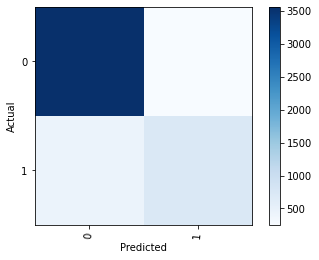

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
def _evaluate(model, x_test):
  model.eval()
  x = torch.Tensor(x_test).float()
  predictions = [1 if i>0.5 else 0 for i in model(x).data]
  predictions = torch.tensor(predictions)
  print('Evaluation on test dataset')
  get_metrics(y_test, predictions)

  # Plot the confusion matrix
  classes=['0','1']
  cm = confusion_matrix(y_test, predictions.numpy())
  plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
  plt.colorbar()
  tick_marks = np.arange(2)
  plt.xticks(tick_marks, classes, rotation=85)
  plt.yticks(tick_marks, classes)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.show()
_evaluate(model, x_test)

Conclusion: Optuna find a neural architecture archiving up to 85.68% accuracy on train dataset and was higher than the original model with only 84.86%.